# Circular track manifold visualisation -- sim & real

In [3]:
import sys, os, time
import numpy as np
import scipy.io as io
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE
from sklearn.model_selection import KFold
import sklearn.metrics.pairwise as mtr
import umap

In [4]:
def cmdscale(D):
    """                                                                                       
    Classical multidimensional scaling (MDS)                                                  

    Parameters                                                                                
    ----------                                                                                
    D : (n, n) array                                                                          
        Symmetric distance matrix.                                                            

    Returns                                                                                   
    -------                                                                                   
    Y : (n, p) array                                                                          
        Configuration matrix. Each column represents a dimension. Only the                    
        p dimensions corresponding to positive eigenvalues of B are returned.                 
        Note that each dimension is only determined up to an overall sign,                    
        corresponding to a reflection.                                                        

    e : (n,) array                                                                            
        Eigenvalues of B.                                                                     

    """
    # Number of points                                                                        
    n = len(D)
    # Centering matrix                                                                        
    H = np.eye(n) - np.ones((n, n))/n
    # YY^T                                                                                    
    B = -H.dot(D**2).dot(H)/2
    # Diagonalize                                                                             
    evals, evecs = np.linalg.eigh(B)
    # Sort by eigenvalue in descending order                                                  
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:,idx]
    # Compute the coordinates using positive-eigenvalued components only                      
    w, = np.where(evals>0)
    L = np.diag(np.sqrt(evals[w]))
    V = evecs[:,w]
    Y = V.dot(L)

    return Y, evals

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    """

    if window_len<3:
        return x

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

def OLE(X, Y):
    # Optimal linear estimator - obtain the estimator's weights
    X = np.c_[np.ones((X.shape[0], 1)), X]
    # obtain the estimator
    return np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))

def LinRec(f, X, Y):
    # Obtain the prediction on the test data
    X = np.c_[np.ones((X.shape[0], 1)), X]  # append a row of ones to the input
    Rec = np.dot(X, f)
    # Evaluate the prediction
    RMSE = np.mean(np.sqrt((Y - Rec)**2))
    R = np.corrcoef(Y, Rec)[0, 1]
    return Rec, RMSE, R

def rec_embd_lle(M_embd, M, k, lam=1):
    # Adapted from https://github.com/jakevdp/pyLLE/blob/master/pyLLE/python_only/LLE.py
    """
    inputs:
       - M: a rank [d * N] data-matrix
       - M_embd: a rank [m * N] matrix which is the output of LLE(M,k,m)
       - k: the number of neighbors to use for the reconstruction
       - lam = regularisation parameter
    returns:
       - y: the LLE reconstruction of x
    """
    # make sure inputs are of the right dimansions and convert to np.matrix
    M = np.matrix(M)
    M_embd = np.matrix(M_embd)
    d,N = M.shape
    m,N2 = M_embd.shape
    assert N==N2    

    # initialise matrix to store eigenvalues
    min_dim = np.min([m,k])
    eig = np.zeros((N,min_dim))
    W = np.matrix(np.zeros((N,N)))

    for i in range(M.shape[1]):
        # find k nearest neighbors
        M_xi = np.array(M_embd - M_embd[:,i])
        vec = (M_xi**2).sum(0)
        nbrs = np.argsort(vec)[1:k+1] # exclude self-neighbour
        
        # compute covariance matrix of distances
        M_xi = np.matrix(M_xi[:,nbrs])
        Q = M_xi.T * M_xi

        # singular values of x give the variance:
        # use this to compute intrinsic dimensionality
        sig2 = (np.linalg.svd(M_xi,compute_uv=0))**2
    
        # Covariance matrix may be nearly singular:
        # add a diagonal correction to prevent numerical errors
        # correction is equal to the sum of the (d-m) unused variances
        # (as in deRidder & Duin)
        r = np.sum(sig2[m:])
        Q += (lam) * np.identity(Q.shape[0])
        # Note that Roewis et al instead uses "a correction that 
        #   is small compared to the trace":
        #r = 0.001 * float(Q.trace())
        
        # solve for weights
        w = np.linalg.solve(Q,np.ones((Q.shape[0],1)))[:,0]
        w /= np.sum(w)

        W[i,nbrs] = w
        sig2 /= sig2.sum()
        eig[i,:] = sig2
#         print('x[%i]: variance conserved: %.2f' % (i, sig2[:m].sum()))
        
    # multiply weights by projections of neighbors to get y
    M_rec = np.array(M * np.matrix(W).T).T
    
    return M_rec, eig

def centre_scale(x):
    xm = x - np.mean(x)
    return xm/np.max(xm)

In [5]:
# Plotting parameters
sns.set(style='ticks',font_scale=2)
AXIS_LIM = 1
colb = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']
plt.set_cmap('hsv') # circular cmap
# make svg text editable in illustrator
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

<Figure size 432x288 with 0 Axes>

In [6]:
# Set path to data
codeDir = os.getcwd()
len2del = len(codeDir.split('/')[-1])
homeDir = codeDir[:-len2del]
figDir = homeDir+'/figures'
figDirSim = figDir+'/03_Figure_sim_manifold'
figDirReal = figDir+'/02_Figure_real_manifold'
figDirAD = figDir+'/04_Figure_AD_manifold'
realDir = homeDir+'dataset/m62_fov2_fam1nov-fam1_STAR'
simPath = homeDir+'dataset/data.mat'
dataDir = homeDir+'dataset/'

DIMS = 5
AXIS_LIM = 1

## Load Data

Loading real data...
Active samples:22081 - Immobility samples:22439


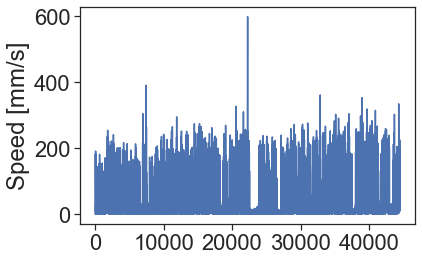

In [8]:
TYP = 1 # 0 to load sim data, 1 to load real ones
# reconstruction parameters
K_lle = 10
LAMBDA = 1

if TYP:
    ds_plt = 1 # downsample for plotting
    LBL = 'real'
    print('Loading real data...')
    for d,folder,files in os.walk(realDir):
        continue
    file = [s for s in files if 'Track' in s]
    temp = io.loadmat(realDir+'/'+file[0])
    phi = temp['phi']; x = temp['x']; y = temp['y']; r = temp['r']
    speed = temp['speed']; Time = temp['time']
    file = [s for s in files if 'spikes' in s]
    temp = io.loadmat(realDir+'/'+file[0])
    spikes = temp['spikes']
    params = temp['params']
    file = [s for s in files if 'fissa' in s]
    temp = io.loadmat(realDir+'/'+file[0])
    dff =  temp['ddf_f']
else:
    ds_plt = 1
    LBL = 'sim'
    print('Loading simulated data...')
    temp = io.loadmat(simPath)
    dff = temp['data'][0][0][0]
    phi = temp['data'][0][0][1]
    t = temp['data'][0][0][2]
    
# find  active times
if TYP:
    speed_thr = 20
    active = speed.flatten() > speed_thr
    print('Active samples:%s - Immobility samples:%s'%(sum(active),sum(~active)))
    plt.plot(speed); plt.ylabel('Speed [mm/s]')
#     filter activity for active times only
    dff_og = dff.copy() # save the full activity
    dff = dff[:,active]
    phi_og = phi.copy() # save the full phi
    phi = phi[active].flatten()
    
# initialise dict to store decoding scores
RMSE = {}; R = {}
var_expl = {}; var_expl_embd = {}
rec_err = {}; rec_corr = {}
var_svd = {}; H = {}

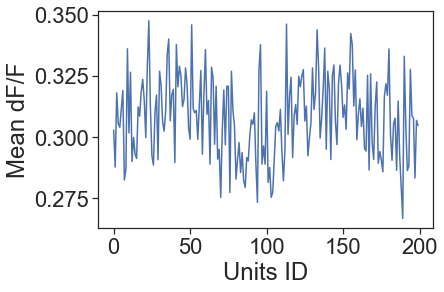

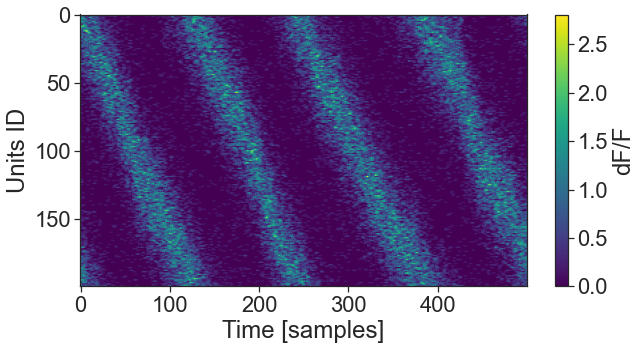

In [6]:
# Plot dFF activity examples
plt.figure(); plt.plot(np.mean(dff,1))
plt.ylabel('Mean dF/F'); plt.xlabel('Units ID')
plt.figure(figsize=(10,5))
plt.imshow(dff[:,:500],cmap='viridis', aspect='auto'); cbar = plt.colorbar()
plt.xlabel('Time [samples]'); plt.ylabel('Units ID')
cbar.set_label('dF/F')

## Absolute dimensionality (E ball)

In [7]:
import pyFCI as fci

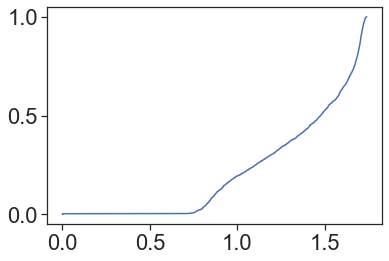

In [15]:
data_ = fci.center_and_normalize(dff)
# fci_exact = fci.FCI(data_)
fci_mc = fci.FCI_MC(data_, 2000)
# plt.plot(fci_exact[:,0], fci_exact[:,1])
plt.plot(fci_mc[:,0], fci_mc[:,1])

In [9]:
# fit = fci.fit_FCI(fci_exact)
# print(fit)
fit = fci.fit_FCI(fci_mc)
print(fit) # fit[0] is dimensionality estimate

[5.425464196444176, 1.0159720532581678, 0.06041480174864647]


In [10]:
import skdim

actmat = dff.T
# actmat = np.random.normal(size=(10000,10))
cpca = skdim.id.MLE(K=5)
%time cpca.fit(actmat).dimension_


CPU times: user 167 ms, sys: 41.9 ms, total: 209 ms
Wall time: 55.1 ms


7.800246589965364

In [20]:
import dimensionality_mle as idim
import gpgFunc3 as gpg

RND = 1

if not RND: # obtain a continuos FR timeseries
    actmat = dff.T
else:# draw a random gaussian d-dimensional ball
    actmat = np.random.normal(size=(10000,100))

%time temp = idim.intrinsic_dim_scale_interval(actmat, k1=5, k2=10)
print('Dim =',np.nanmean(temp))

CPU times: user 17 s, sys: 4.43 s, total: 21.4 s
Wall time: 16.6 s
Dim = 49.82475318620987


CPU times: user 7.87 s, sys: 1.01 s, total: 8.88 s
Wall time: 7.99 s


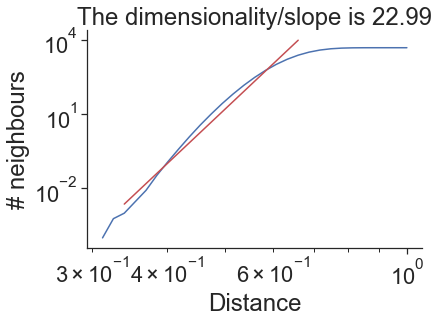

In [21]:
ds = 1 # downsmapling factor
nstep = 30
points = actmat[::ds]
%time Nneigh, radii, p = gpg.abs_dimensionality(points, nstep=nstep, metric='cosine')

In [23]:
def new_LLE_pts(M, M_LLE, k, x, lam=1):
    # Adapted from https://github.com/jakevdp/pyLLE/blob/master/pyLLE/python_only/LLE.py
    """
    inputs:
       - M: a rank [d * N] data-matrix
       - M_LLE: a rank [m * N] matrixwhich is the output of LLE(M,k,m)
       - k: the number of neighbors used to produce M_LLE
       - x: a length d data vector OR a rank [d * Nx] array
    returns:
       - y: the LLE reconstruction of x
    """
    # make sure inputs are correct
    d,N = M.shape
    m,N2 = M_LLE.shape
    assert N==N2
    Nx = x.shape[1]
    W = np.zeros([Nx,N])

    for i in range(x.shape[1]):
        #  find k nearest neighbors
        M_xi = M-np.atleast_2d(x[:,i]).T
        vec = (M_xi**2).sum(0)
        nbrs = np.argsort(vec)[1:k+1]
        
        #compute covariance matrix of distances
        M_xi = M_xi[:,nbrs]
        Q = M_xi.T @ M_xi

        #singular values of x give the variance:
        # use this to compute intrinsic dimensionality
        sig2 = (np.linalg.svd(M_xi,compute_uv=0))**2
    
        #Covariance matrix may be nearly singular:
        # add a diagonal correction to prevent numerical errors
        Q += (lam) * np.identity(Q.shape[0])

        #solve for weight
        w = np.linalg.solve(Q,np.ones((Q.shape[0],1)))[:,0]
        w /= np.sum(w)

        W[i,nbrs] = w
    
    return np.array( M_LLE  * np.matrix(W).T ).T


def rec_embd_lle(M_embd, M, k, lam=1, verbose=0):
    # Adapted from https://github.com/jakevdp/pyLLE/blob/master/pyLLE/python_only/LLE.py
    """
    inputs:
       - M: a rank [d * N] data-matrix
       - M_embd: a rank [m * N] matrix which is the output of LLE(M,k,m)
       - k: the number of neighbors to use for the reconstruction
       - lam = regularisation parameter
    returns:
       - y: the LLE reconstruction of x
    """
    # make sure inputs are of the right dimansions and convert to np.matrix
    M = np.matrix(M)
    M_embd = np.matrix(M_embd)
    d,N = M.shape
    m,N2 = M_embd.shape
    assert N==N2    

    # initialise matrix to store eigenvalues
    min_dim = np.min([m,k])
    eig = np.zeros((N,min_dim))
    W = np.matrix(np.zeros((N,N)))

    for i in range(M.shape[1]):
        # find k nearest neighbors
        M_xi = np.array(M_embd - M_embd[:,i])
        vec = (M_xi**2).sum(0)
        nbrs = np.argsort(vec)[1:k+1] # exclude self-neighbour
        
        # compute covariance matrix of distances
        M_xi = np.matrix(M_xi[:,nbrs])
        Q = M_xi.T * M_xi

        # singular values of x give the variance:
        # use this to compute intrinsic dimensionality
        sig2 = (np.linalg.svd(M_xi,compute_uv=0))**2
    
        # Add regulirisation term to covariance matrix
        r = np.sum(sig2[m:])
        Q += (lam) * np.identity(Q.shape[0])
        
        # solve for weights
        w = np.linalg.solve(Q,np.ones((Q.shape[0],1)))[:,0]
        w /= np.sum(w)

        # store variables
        W[i,nbrs] = w
        sig2 /= sig2.sum()
        eig[i,:] = sig2
        if verbose: print('x[%i]: variance conserved: %.2f' % (i, sig2[:m].sum()))
        
    # multiply weights by projections of neighbors to get y
    M_rec = np.array(M * np.matrix(W).T).T
    
    return M_rec, eig

## Cosine distance matrix

In [25]:
# obtain cosine distance matrix
if TYP: down = 3 # downsampling factor for speeding up calculations
else: down = 1 # no downsampling foir sim data
X = dff[:,::down].T
D = cosine_distances(X)

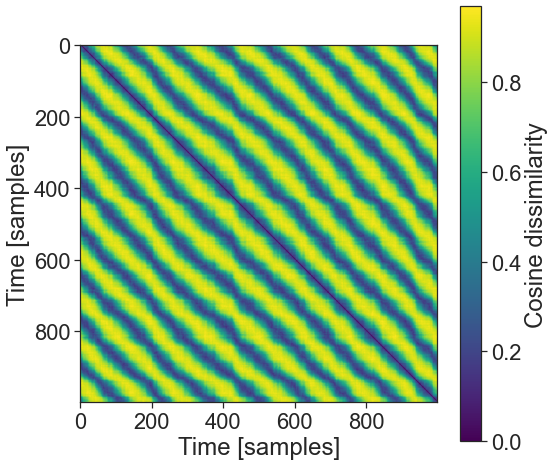

In [26]:
plt.figure(figsize=(8,8))
plt.imshow(D,cmap='viridis'); cbar = plt.colorbar(); cbar.set_label('Cosine dissimilarity')
plt.xlabel('Time [samples]'); plt.ylabel('Time [samples]');

## PCA

In [27]:
X.shape

(1000, 200)

In [28]:
pca = PCA(n_components=DIMS)
x_embd = pca.fit_transform(X)
x_embd = x_embd / np.max(np.abs(x_embd)) # normalise the values
AXIS_LIM = np.max(x_embd)

<Figure size 432x288 with 0 Axes>

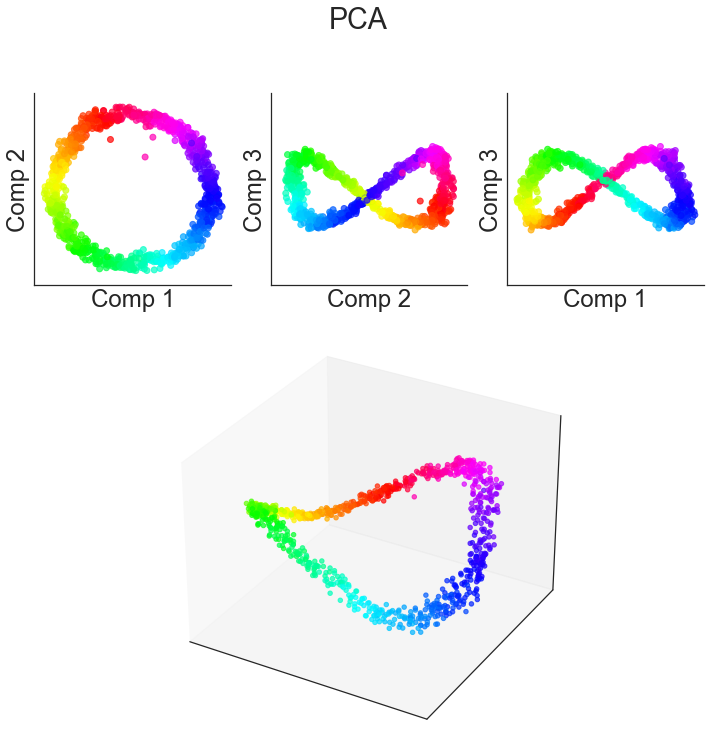

In [29]:
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('PCA')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down][::ds_plt]
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/PCA_'+LBL+'.png')
    plt.savefig(figDirReal+'/PCA_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/PCA_'+LBL+'.png')
    plt.savefig(figDirSim+'/PCA_'+LBL+'.svg')

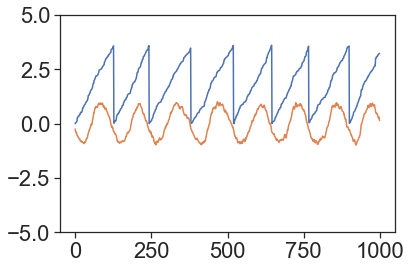

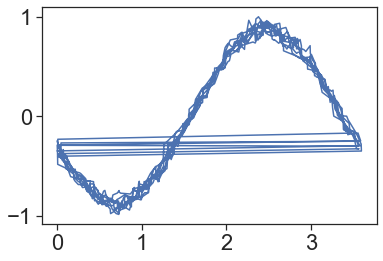

In [30]:
plt.plot(phi.T/100)
plt.plot(x_embd[:,0])
plt.ylim(-5,5)
plt.figure()
plt.plot(phi.T/100, x_embd[:,0])

In [31]:
### OLE  decoding
EMBD = 'PCA'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [433]:
# ### Dimensionality score

# # scale Y to match X
# Y = x_embd
# radY = np.percentile(Y-np.mean(Y), 95)
# radX = np.percentile(X-np.mean(X), 95)
# Y_sc = radX/radY * (Y-np.mean(Y))

# ### Reconstruction error
# var_expl[EMBD] = []
# rec_err[EMBD] = []
# for dim in range(DIMS):
#     # obtain og high-dim activity and its embedding
#     if TYP:
#         Y = Y_sc[::2,:dim+1]
#         X_ = X[::2].copy()
#     else:
#         Y = Y_sc[:,:dim+1]
#         X_ = X.copy()
#     # obtain the RBF interpolation  of the embedding
#     gamma = np.var(Y)*10
#     K = mtr.pairwise_kernels(Y, metric='rbf', gamma=gamma)
#     # Obtain inverse-mapping A
#     A = np.linalg.pinv(K).dot(X_)
#     # Reconstruct the data
#     X_rec = np.dot(K,A)
#     s1 = np.mean((X_ - X_rec)**2)
#     s2 = np.mean((X_ - np.mean(X_))**2)
#     var_expl[EMBD].append(1 - s1/s2)
#     rec_err[EMBD].append(np.mean(np.sqrt((X_-X_rec)**2)))
#     print('.')
    
# ### E-ball fit
# H[EMBD] = []
# for dim in range(DIMS):
#     Y = Y_sc[:,:dim+1]
#     for n in range(2): # loop for +ve / -ve unit vectors
#         for d in range(dim+1):
#             v = np.zeros(dim+1)
#             if n: v[d] = 1
#             else: v[d] = -1
#             # Apply it to test data
#             H[EMBD].append(np.min(np.sqrt((v-Y)**2)))

In [32]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


Text(0.5, 1.0, 'Reconstructed')

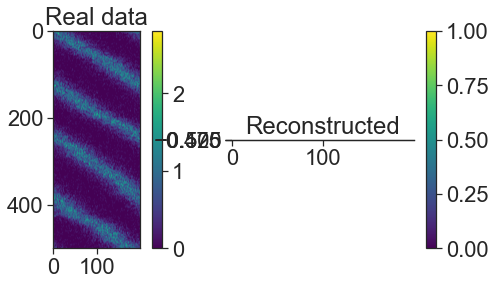

In [435]:
# Visualise a reconstruction example
plt.figure(figsize=(9,4));
plt.subplot(121)
plt.imshow(X_[:500],cmap='viridis'); plt.colorbar()
plt.title('Real data')
plt.subplot(122)
plt.imshow(X_rec[:00],cmap='viridis'); plt.colorbar()
plt.title('Reconstructed')

## CMDSCALE (classic  MDS)

In [33]:
# fit embedding
x_embd,eig_mds_dff = cmdscale(D)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

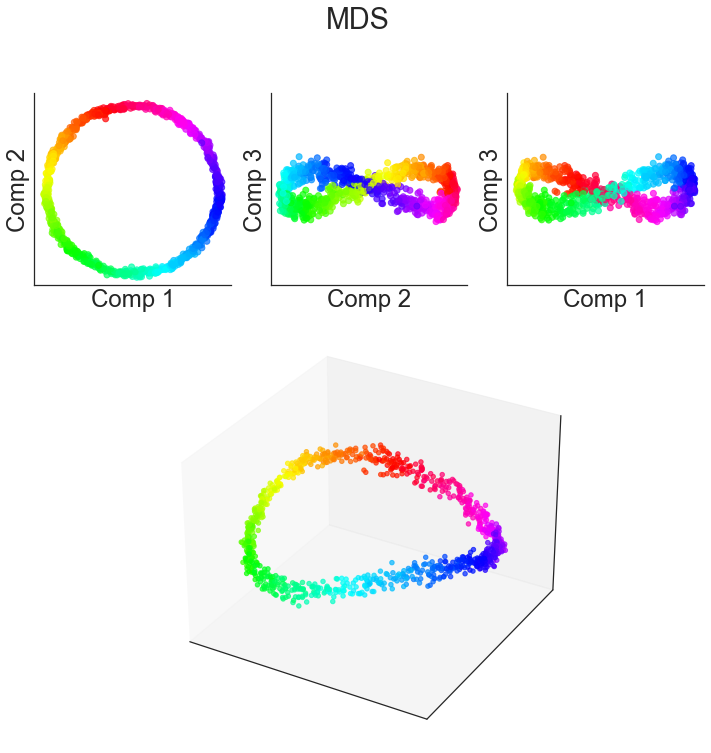

In [34]:
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('MDS')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down][::ds_plt]
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/MDS_'+LBL+'.png')
    plt.savefig(figDirReal+'/MDS_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/MDS_'+LBL+'.png')
    plt.savefig(figDirSim+'/MDS_'+LBL+'.svg')

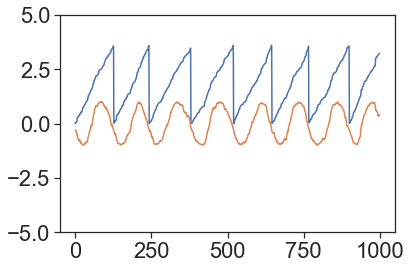

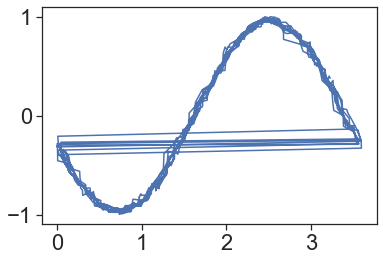

In [35]:
plt.plot(phi.T/100)
plt.plot(x_embd[:,0])
plt.ylim(-5,5)
plt.figure()
plt.plot(phi.T/100, x_embd[:,0])

Text(0.5, 0, 'Number of dimensions')

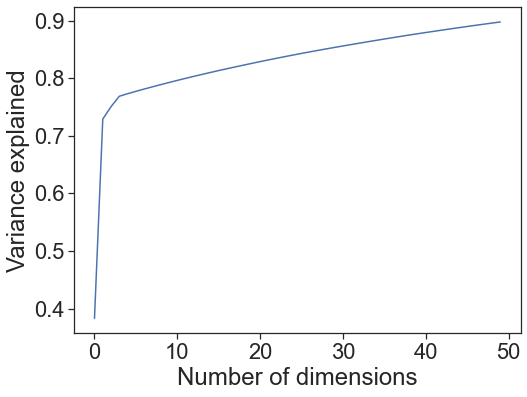

In [36]:
evals_mds_ = eig_mds_dff[eig_mds_dff>0] / np.sum(eig_mds_dff[eig_mds_dff>0])
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(evals_mds_)[:50])
plt.ylabel('Variance explained')
plt.xlabel('Number of dimensions')

In [37]:
### OLE  decoding
EMBD = 'MDS'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [440]:
# ### Dimensionality score

# # scale Y (low dim) to match X (high dim)
# Y = x_embd
# radY = np.percentile(Y-np.mean(Y), 95)
# radX = np.percentile(X-np.mean(X), 95)
# Y_sc = radX/radY * (Y-np.mean(Y))

# ### Reconstruction error
# var_expl[EMBD] = []
# rec_err[EMBD] = []
# for dim in range(1):
#     # obtain og high-dim activity and its embedding
#     if TYP:
#         Y = Y_sc[::2,:dim+1]
#         X_ = X[::2].copy()
#     else:
#         Y = Y_sc[:,:dim+1]
#         X_ = X.copy()
#     # obtain the RBF interpolation  of the embedding
#     gamma = np.var(Y)*10
#     K = mtr.pairwise_kernels(Y, metric='rbf', gamma=gamma)
#     # Obtain inverse-mapping A
#     A = np.linalg.pinv(K).dot(X_)
#     # Reconstruct the data
#     X_rec = np.dot(K,A)
#     s1 = np.mean((X_ - X_rec)**2)
#     s2 = np.mean((X_ - np.mean(X_))**2)
#     var_expl[EMBD].append(1 - s1/s2)
#     rec_err[EMBD].append(np.mean(np.sqrt((X_-X_rec)**2)))
#     print('.')
    
# ### E-ball fit
# H[EMBD] = []
# for dim in range(DIMS):
#     Y = Y_sc[:,:dim+1]
#     for n in range(2): # loop for +ve / -ve unit vectors
#         for d in range(dim+1):
#             v = np.zeros(dim+1)
#             if n: v[d] = 1
#             else: v[d] = -1
#             # Apply it to test data
#             H[EMBD].append(np.min(np.sqrt((v-Y)**2)))

In [38]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


Text(0.5, 1.0, 'Reconstructed')

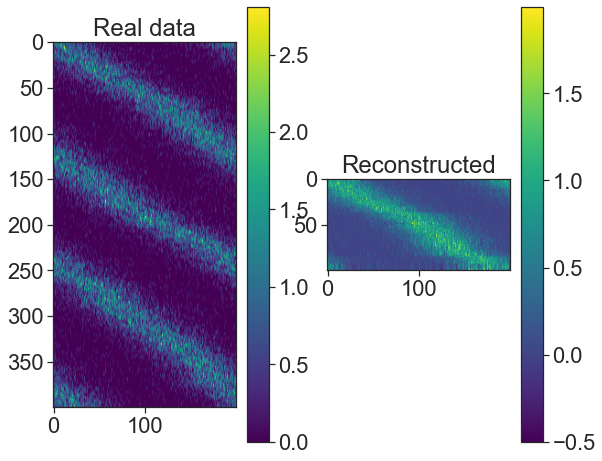

In [39]:
# Visualise a reconstruction example
plt.figure(figsize=(9,8));
plt.subplot(121);
plt.imshow(X_[:400],cmap='viridis'); plt.colorbar()
plt.title('Real data')
plt.subplot(122)
plt.imshow(X_rec[:400],cmap='viridis'); plt.colorbar()
plt.title('Reconstructed')

## ISOMAP

In [40]:
# fit embedding
COS = 1 # set to 1 for embedding the cosine distance matrix
if COS:
    if TYP: isomap = Isomap(n_components=DIMS, n_neighbors=40)
    else: isomap = Isomap(n_components=DIMS, n_neighbors=10)
    x_embd = isomap.fit_transform(D)
else:
    if TYP: isomap = Isomap(n_components=DIMS, n_neighbors=40, metric='minkowski')
    else: isomap = Isomap(n_components=DIMS, n_neighbors=10, metric='minkowski')
    x_embd = isomap.fit_transform(X)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

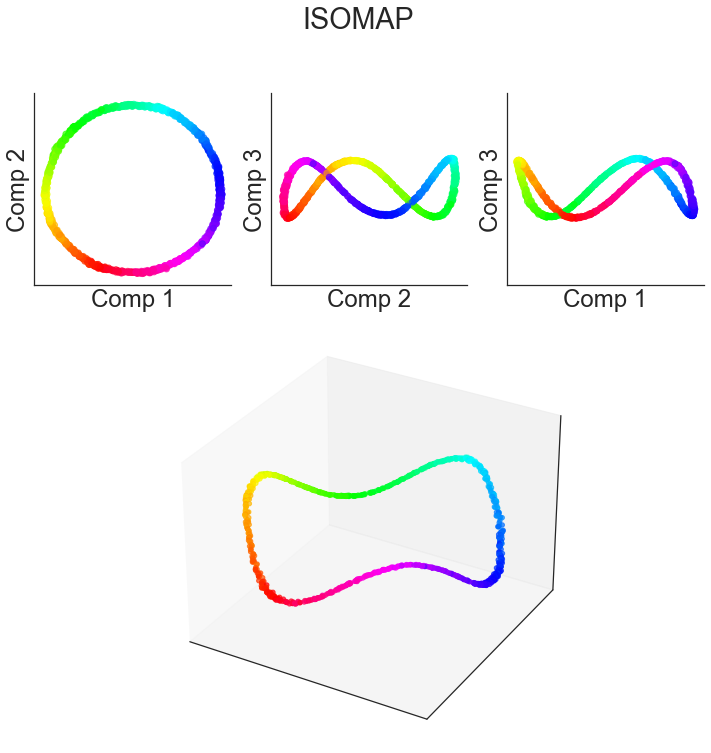

In [41]:
plt.set_cmap('hsv') # circular cmap
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('ISOMAP')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down][::ds_plt]
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlim([-AXIS_LIM,AXIS_LIM])
ax.set_ylim([-AXIS_LIM,AXIS_LIM])
ax.set_zlim([-AXIS_LIM,AXIS_LIM])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/Isomap_'+LBL+'.png')
    plt.savefig(figDirReal+'/Isomap_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/Isomap_'+LBL+'.png')
    plt.savefig(figDirSim+'/Isomap_'+LBL+'.svg')

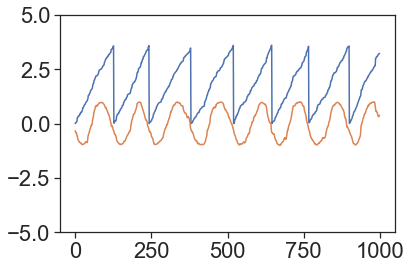

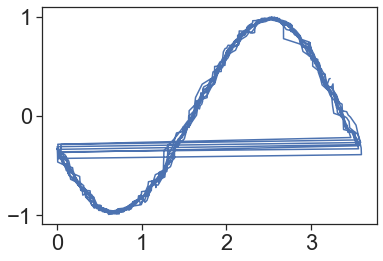

In [42]:
plt.plot(phi.T/100)
plt.plot(x_embd[:,0])
plt.ylim(-5,5)
plt.figure()
plt.plot(phi.T/100, x_embd[:,0])

In [43]:
### OLE  decoding
EMBD = 'ISO'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [44]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


Text(0.5, 1.0, 'Reconstructed')

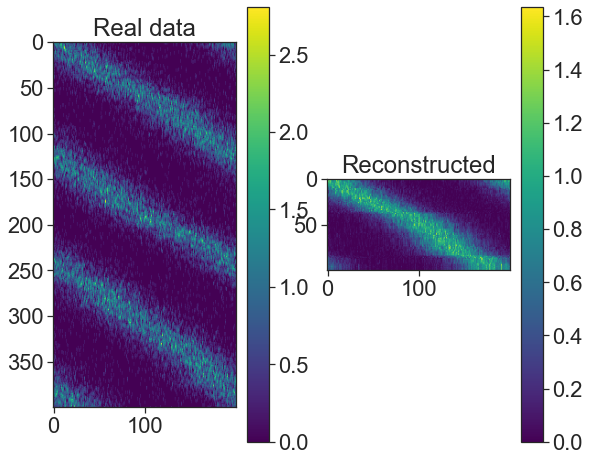

In [448]:
# Visualise a reconstruction example
plt.figure(figsize=(9,8));
plt.subplot(121);
plt.imshow(X_[:400],cmap='viridis'); plt.colorbar()
plt.title('Real data')
plt.subplot(122)
plt.imshow(X_rec[:400],cmap='viridis'); plt.colorbar()
plt.title('Reconstructed')

## LLE

In [45]:
# fit embedding
if TYP: 
    lle = LocallyLinearEmbedding(n_components=DIMS, n_neighbors=60, method='modified')
    x_embd = lle.fit_transform(D)
else:
    lle = LocallyLinearEmbedding(n_components=DIMS, n_neighbors=10, method='modified')
    x_embd = lle.fit_transform(X)
x_embd = centre_scale(x_embd)

<Figure size 432x288 with 0 Axes>

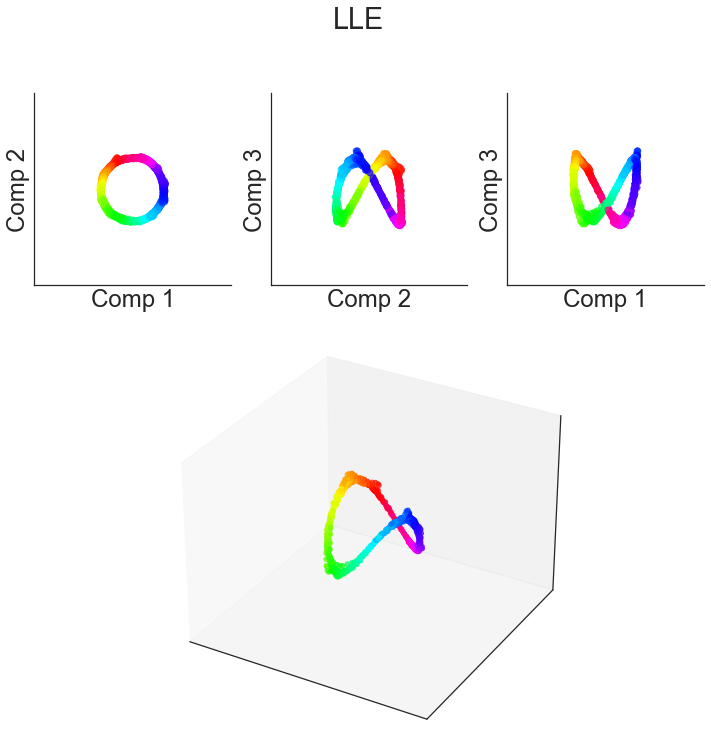

In [46]:
plt.set_cmap('hsv') # circular cmap
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('LLE')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down]
scat = ax.scatter(x_embd[:,0], x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/LLE_'+LBL+'.png')
    plt.savefig(figDirReal+'/LLE_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/LLE_'+LBL+'.png')
    plt.savefig(figDirSim+'/LLE_'+LBL+'.svg')

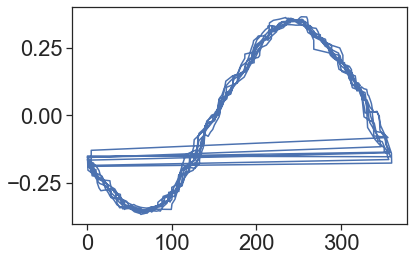

In [47]:
plt.plot(cmap.T, x_embd[:,0])

In [48]:
### OLE  decoding
EMBD = 'LLE'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [49]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


## Laplacian eigenmaps (Spectral embedding)

In [50]:
# fit embedding
if TYP:
    SE = SpectralEmbedding(n_components=DIMS, affinity='nearest_neighbors', n_neighbors=40)
    x_embd = SE.fit_transform(D)
else:
    SE = SpectralEmbedding(n_components=DIMS, affinity='nearest_neighbors', n_neighbors=10)
    x_embd = SE.fit_transform(X)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

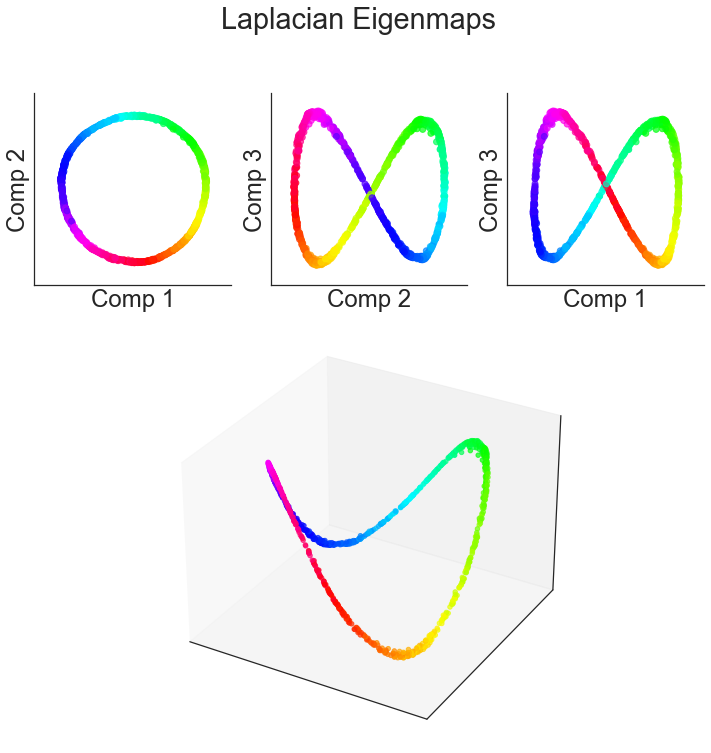

In [51]:
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('Laplacian Eigenmaps')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down]
scat = ax.scatter(x_embd[:,0], x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/Laplacian_'+LBL+'.svg')
    plt.savefig(figDirReal+'/Laplacian_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/Laplacian_'+LBL+'.svg')
    plt.savefig(figDirSim+'/Laplacian_'+LBL+'.png')

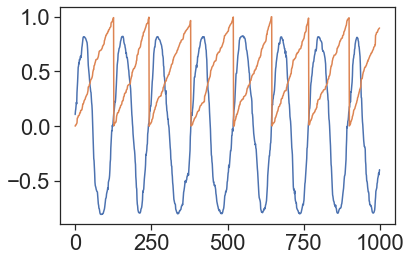

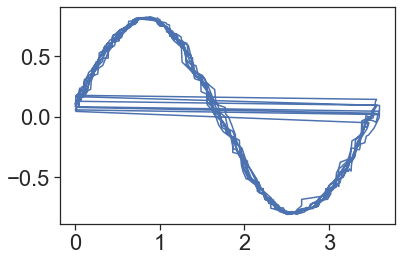

In [52]:
plt.plot(x_embd[:,0])
plt.plot(phi[0]/np.max(phi))
plt.figure()
plt.plot(phi[::down].T/100, x_embd[:,0])

In [53]:
### OLE  decoding
EMBD = 'LEM'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [54]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


## GPFA

In [11]:
TYP = 1

In [12]:
if TYP:
    LBL = 'real'
    temp = io.loadmat(dataDir+'gpfaOutput_real.mat')
    x_embd = np.array(temp['gpfaOutput'][0,0][0]).T
    x_embd = x_embd / np.max(x_embd) # normalise
    phi_ = np.array(temp['gpfaOutput'][0,0][1]).flatten()
    temp2 = io.loadmat(dataDir+'gpfaData_Real.mat')
    data_ = temp2['dataReal'][0][0][0].T # data, pos, time, spikes
else:
    LBL = 'sim'
    temp = io.loadmat(dataDir+'gpfaOutput_simulated.mat')
    x_embd = np.array(temp['gpfaOutputSim'][0,0][0]).T
    x_embd = x_embd / np.max(x_embd) # normalise
    phi_ = np.array(temp['gpfaOutputSim'][0,0][1]).flatten()
    temp2 = io.loadmat(dataDir+'gpfaData_Simulated.mat')
    data_ = np.array(temp2['data'][0,0][0]).T # data, pos, 

In [13]:
phi_.shape, x_embd.shape, data_.shape

((2183,), (2183, 8), (7361, 138))

<Figure size 432x288 with 0 Axes>

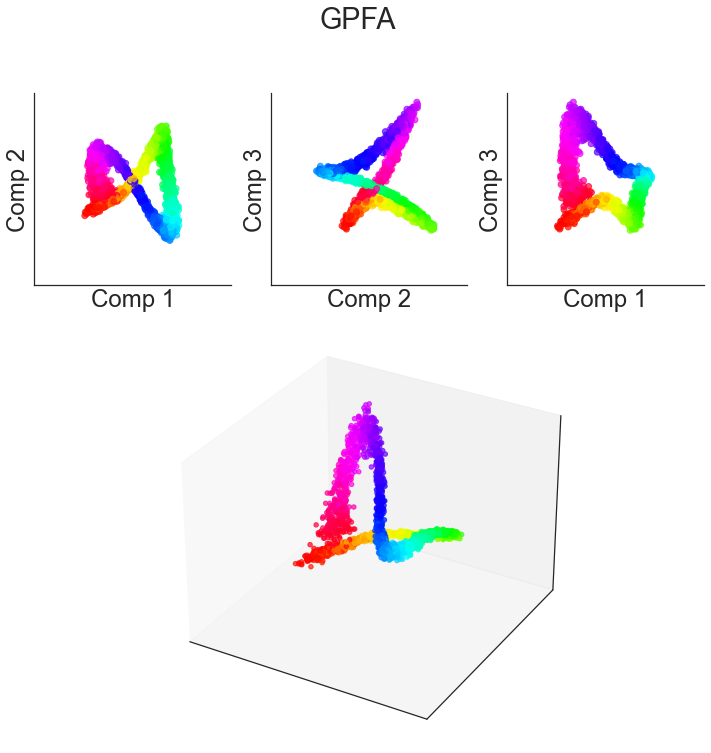

In [57]:
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('GPFA')
# 3D projectiona
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi_
scat = ax.scatter(x_embd[:,0], x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3Z
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# saving
if TYP:
    plt.savefig(figDirReal+'/gpfa_'+LBL+'.svg')
    plt.savefig(figDirReal+'/gpfa_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/gpfa_'+LBL+'.svg')
    plt.savefig(figDirSim+'/gpfa_'+LBL+'.png')

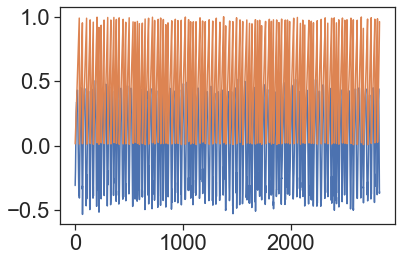

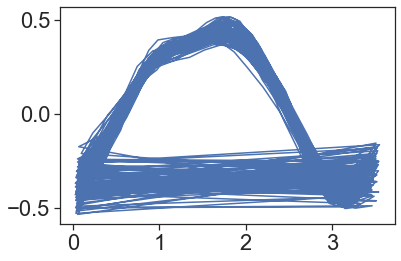

In [58]:
plt.plot(x_embd[:,0])
plt.plot(phi_.T/np.max(phi_))
plt.figure()
plt.plot(phi_.T/100, x_embd[:,0])

In [59]:
### OLE  decoding
EMBD = 'GPFA'
N = DIMS
cv = 10
Y = phi_ # angular position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [60]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


## tSNE

In [71]:
# fit embedding
if TYP:
    SE = TSNE(n_components=3, metric='cosine', perplexity=90, random_state=42)
    x_embd = SE.fit_transform(X)
else:
    SE = TSNE(n_components=3, metric='cosine', perplexity=30, random_state=42)
    x_embd = SE.fit_transform(X)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

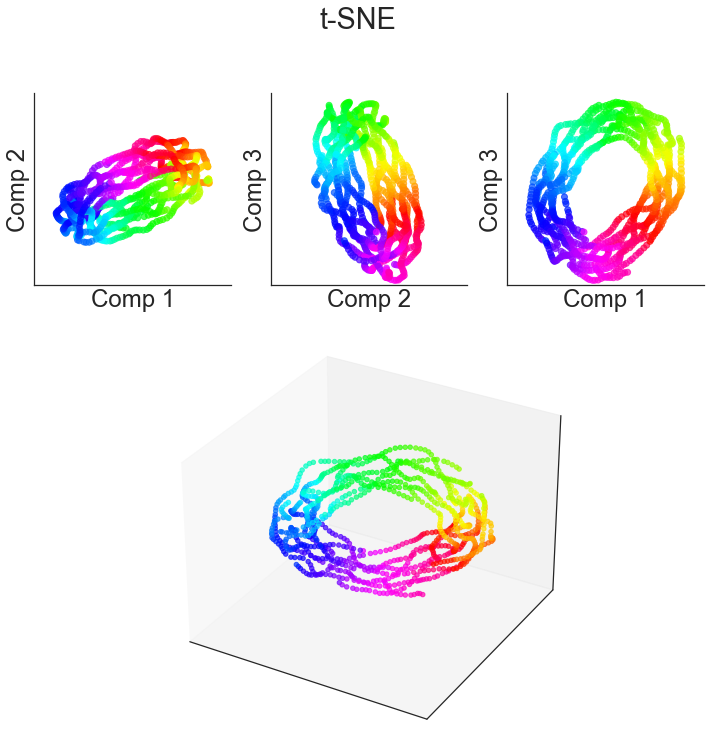

In [72]:
plt.set_cmap('hsv') # circular cmap
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
cmap = phi[::down][::ds_plt]
plt.suptitle('t-SNE')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/tSNE_'+LBL+'.png')
    plt.savefig(figDirReal+'/tSNE_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/tSNE_'+LBL+'.png')
    plt.savefig(figDirSim+'/tSNE_'+LBL+'.svg')

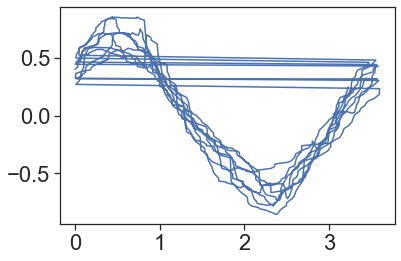

In [73]:
plt.plot(phi.T/100, x_embd[:,0])

In [74]:
### OLE  decoding
EMBD = 't-SNE'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.ones((N,cv))*np.nan; R[EMBD] = np.ones((N,cv))*np.nan
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [75]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


## UMAP

In [76]:
from sklearn.preprocessing import StandardScaler
# fit embedding
if TYP:
    SE = umap.UMAP(n_components=DIMS, metric='cosine', n_neighbors=160, random_state=42)
    x_embd = SE.fit_transform(X)
else:
    SE = umap.UMAP(n_components=DIMS, metric='cosine', n_neighbors=20, random_state=4)
    x_embd = SE.fit_transform(X)
x_embd = centre_scale(x_embd)

<Figure size 432x288 with 0 Axes>

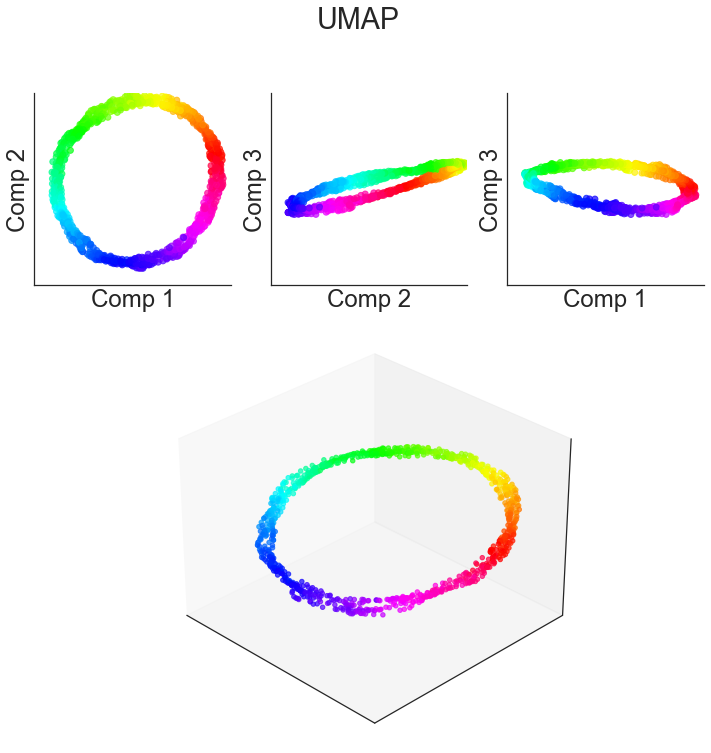

In [77]:
plt.set_cmap('hsv') # circular cmap
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
cmap = phi[::down][::ds_plt]
MIN = np.min(x_embd)
plt.suptitle('UMAP')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
scat = ax.scatter(-x_embd[:,0][::ds_plt], -x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
ax.view_init(elev=30., azim=-45)
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(MIN,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(MIN),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(MIN,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(MIN),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(MIN,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(MIN),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(-x_embd[:,0][::ds_plt], -x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN-.1,AXIS_LIM+.1]); ax.set_ylim([MIN-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(-x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN-.1,AXIS_LIM+.1]); ax.set_ylim([MIN-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(-x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN-.1,AXIS_LIM+.1]); ax.set_ylim([MIN-.1,AXIS_LIM+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/UMAP_'+LBL+'.png')
    plt.savefig(figDirReal+'/UMAP_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/UMAP_'+LBL+'.png')
    plt.savefig(figDirSim+'/UMAP_'+LBL+'.svg')

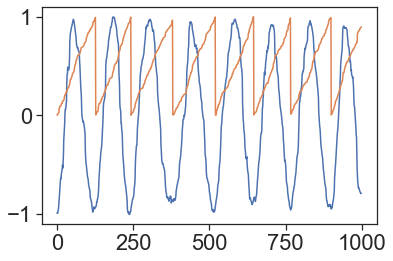

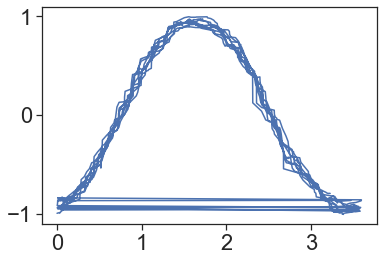

In [78]:
plt.plot(x_embd[:,0])
plt.plot(phi[0]/np.max(phi))
plt.figure()
plt.plot(phi.T/100, x_embd[:,0])

In [79]:
### OLE  decoding
EMBD = 'UMAP'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.ones((N,cv))*np.nan; R[EMBD] = np.ones((N,cv))*np.nan
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [80]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


## Linear Decoding - OLE

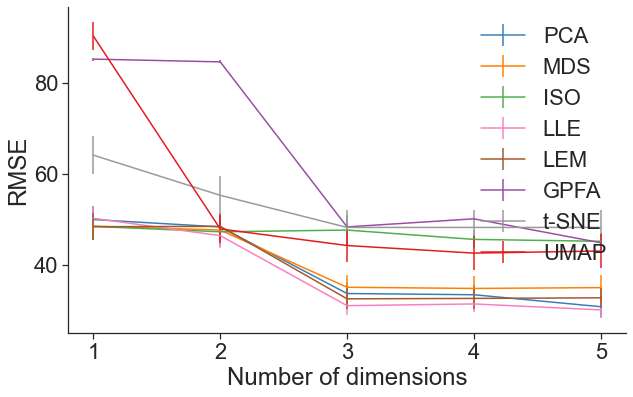

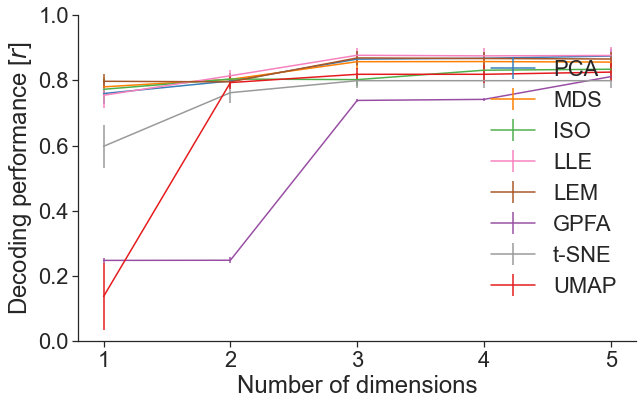

In [81]:
sns.set(style='ticks', font_scale=2)
plt.figure(figsize=(10,6))
for n,k in enumerate(R):
    sem = stats.sem(RMSE[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(RMSE[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.legend(frameon=False, loc=1)
plt.xticks(range(1,DIMS+1))
plt.ylabel('RMSE')
plt.xlabel('Number of dimensions')
sns.despine()
# saving
if TYP:
    plt.savefig(figDirReal+'/decode_rmseErr_'+LBL+'.svg')
    plt.savefig(figDirReal+'/decode_rmseErr_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/decode_rmseErr_'+LBL+'.svg')
    plt.savefig(figDirSim+'/decode_rmseErr_'+LBL+'.png')

plt.figure(figsize=(10,6))
for n,k in enumerate(R):
    sem = stats.sem(R[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(R[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.ylim(0,1)
plt.xticks(range(1,DIMS+1))
plt.ylabel('Decoding performance [$r$]')
plt.xlabel('Number of dimensions')
plt.legend(frameon=False, loc=5)
sns.despine()
# saving
if TYP:
    plt.savefig(figDirReal+'/decode_corrErr_'+LBL+'.svg')
    plt.savefig(figDirReal+'/decode_corrErr_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/decode_corrErr_'+LBL+'.svg')
    plt.savefig(figDirSim+'/decode_corrErr_'+LBL+'.png')

### Variance explained / reconstruction error

In [82]:
keys = list(var_expl.keys())
if 'GPFA' in keys: keys.remove('GPFA')

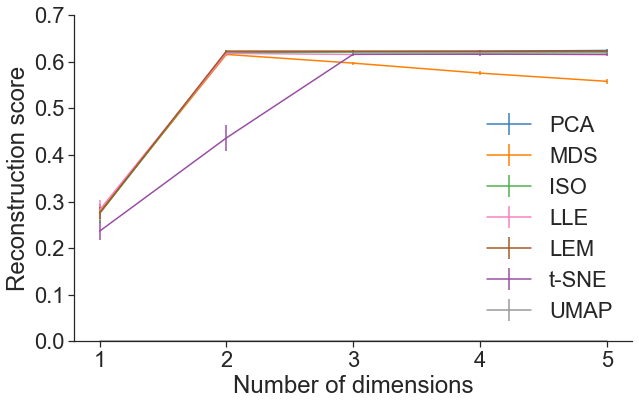

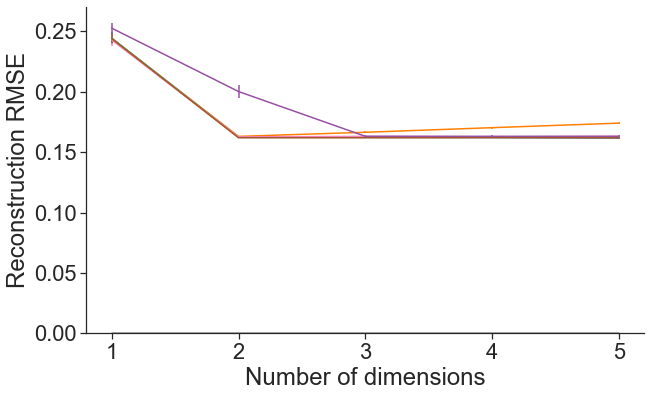

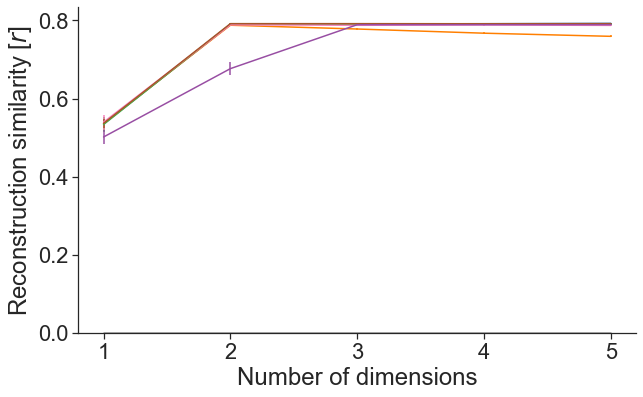

In [99]:
# Non-linear  variance explained
plt.figure(figsize=(10,6))
for n,k in enumerate(keys):
    sem = stats.sem(var_expl[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(var_expl[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.legend(frameon=False,loc=4)
if TYP: plt.ylim(0,.6)
else: plt.ylim(0,.7)
plt.xticks(range(1,DIMS+1))
plt.ylabel('Reconstruction score')
plt.xlabel('Number of dimensions')
sns.despine()
# saving
if TYP:
    plt.savefig(figDirReal+'/var_expl_'+LBL+'.svg')
    plt.savefig(figDirReal+'/var_expl_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/var_expl_'+LBL+'.svg')
    plt.savefig(figDirSim+'/var_expl_'+LBL+'.png')

# Reconstuction error
plt.figure(figsize=(10,6))
for n,k in enumerate(keys):
    sem = stats.sem(rec_err[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(rec_err[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.ylim(0)
plt.ylabel('Reconstruction RMSE')
plt.xlabel('Number of dimensions')
plt.xticks(range(1,DIMS+1))
sns.despine()
# saving
if TYP:
    plt.savefig(figDirReal+'/rec_err_'+LBL+'.svg')
    plt.savefig(figDirReal+'/rec_err_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/rec_err_'+LBL+'.svg')
    plt.savefig(figDirSim+'/rec_err_'+LBL+'.png')
    
# Reconstuction correlation
plt.figure(figsize=(10,6))
for n,k in enumerate(keys):
    sem = stats.sem(rec_corr[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(rec_corr[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.ylim(0)
plt.ylabel('Reconstruction similarity [$r$]')
plt.xlabel('Number of dimensions')
plt.xticks(range(1,DIMS+1))
sns.despine()
# saving
if TYP:
    plt.savefig(figDirReal+'/rec_corr_'+LBL+'.svg')
    plt.savefig(figDirReal+'/rec_corr_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/rec_corr_'+LBL+'.svg')
    plt.savefig(figDirSim+'/rec_corr_'+LBL+'.png')

## cvPCA

In [350]:
if TYP:
    LBL = 'real'
    temp = io.loadmat(dataDir+'cvpcaOutput_real.mat')
    x_embd = np.array(temp['cvpca_real'][0,0][0]).T
    x_embd = x_embd / np.max(x_embd) # normalise
    phi_ = np.array(temp['cvpca_real'][0,0][1]).flatten()
else:
    LBL = 'sim'
    temp = io.loadmat(dataDir+'cvpcaOutput_simulated.mat')
    x_embd = np.array(temp['cvpca_sim'][0,0][0]).T
    x_embd = x_embd / np.max(x_embd) # normalise
    phi_ = np.array(temp['cvpca_sim'][0,0][1]).flatten()

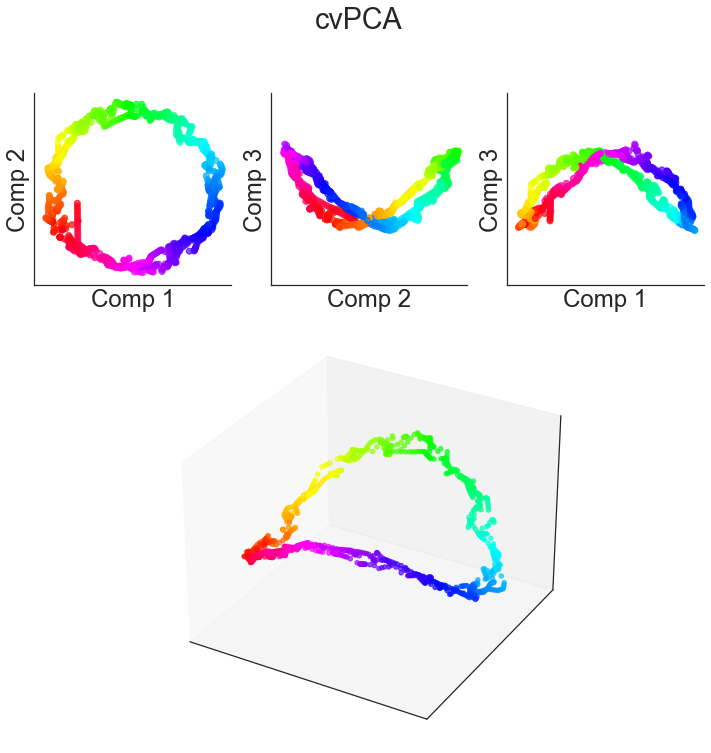

In [351]:
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('cvPCA')
# 3D projectiona
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi_
scat = ax.scatter(x_embd[:,0], x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN-.1,AXIS_LIM+.1]); ax.set_ylim([MIN-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN-.1,AXIS_LIM+.1]); ax.set_ylim([MIN-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN-.1,AXIS_LIM+.1]); ax.set_ylim([MIN-.1,AXIS_LIM+.1])
sns.despine()

# saving
if TYP:
    plt.savefig(figDirReal+'/cvpca_'+LBL+'.svg')
    plt.savefig(figDirReal+'/cvpca_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/cvpca_'+LBL+'.svg')
    plt.savefig(figDirSim+'/cvpca_'+LBL+'.png')

In [125]:
### OLE  decoding
EMBD = 'cvpca'
N = 3
cv = 10
Y = phi_.flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

## AD simulation

In [86]:
temp = io.loadmat(dataDir+'simulatedADdata.mat')
dff_ad = temp['data'][0][0][0]
phi_ad = temp['data'][0][0][1]
t_ad = temp['data'][0][0][2]

In [87]:
X_ad = dff_ad.T
D_ad = 1 - cosine_similarity(X_ad) # dF/F

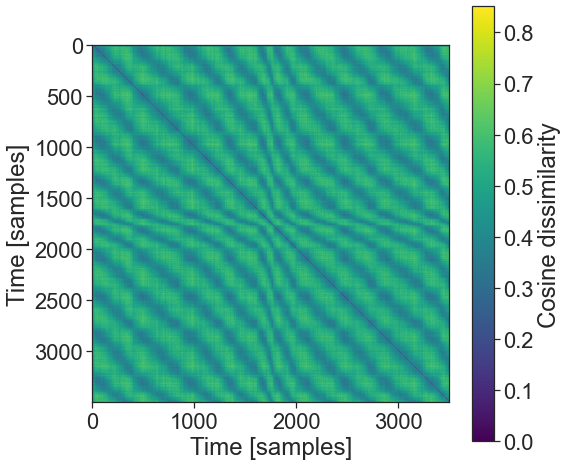

In [88]:
plt.figure(figsize=(8,8))
plt.imshow(D_ad, cmap='viridis'); cbar = plt.colorbar(); cbar.set_label('Cosine dissimilarity')
plt.xlabel('Time [samples]'); plt.ylabel('Time [samples]');

### MDS embedding

In [89]:
# fit embedding
x_embd,eig_mds_dff = cmdscale(D_ad)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

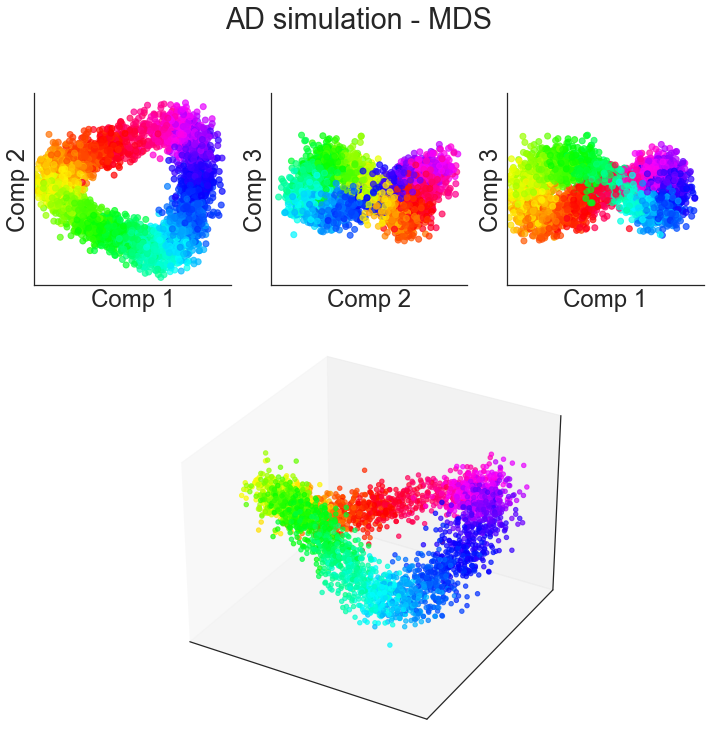

In [90]:
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('AD simulation - MDS')
# 3D projectiona
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi_ad
scat = ax.scatter(x_embd[:,0], x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([-AXIS_LIM,AXIS_LIM])
ax.set_ylim([-AXIS_LIM,AXIS_LIM])
ax.set_zlim([-AXIS_LIM,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

# saving
plt.savefig(figDirAD+'/MDS_simAD.svg')
plt.savefig(figDirAD+'/MDS_simAD.png')

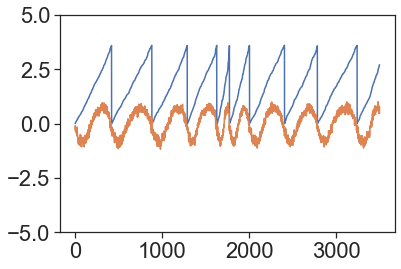

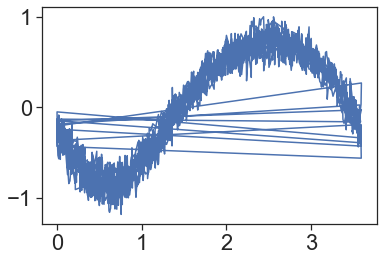

In [91]:
plt.plot(phi_ad.T/100)
plt.plot(x_embd[:,0])
plt.ylim(-5,5)
plt.figure()
plt.plot(phi_ad.T/100, x_embd[:,0])

In [92]:
### OLE  decoding
EMBD = 'mds_ad'
N = DIMS
cv = 10
Y = phi_ad.flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

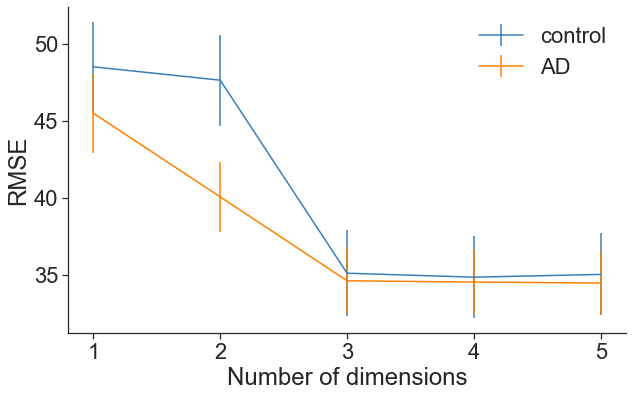

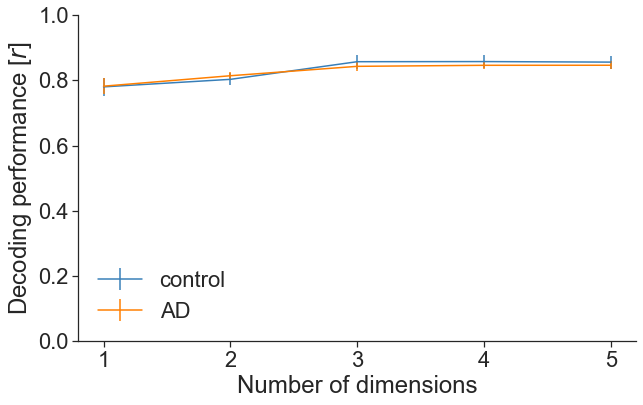

In [93]:
sns.set(style='ticks', font_scale=2)
plt.figure(figsize=(10,6))
sem = stats.sem(RMSE['MDS'],1, nan_policy='omit')
plt.errorbar(range(1,DIMS+1), np.nanmean(RMSE['MDS'],1), yerr=sem, label='control', color=colb[0], alpha=1)
sem = stats.sem(RMSE['mds_ad'],1, nan_policy='omit')
plt.errorbar(range(1,DIMS+1), np.nanmean(RMSE['mds_ad'],1), yerr=sem, label='AD', color=colb[1], alpha=1)
plt.legend(frameon=False)
plt.xticks(range(1,DIMS+1))
plt.ylabel('RMSE')
plt.xlabel('Number of dimensions')
sns.despine()
# saving
plt.savefig(figDirAD+'/decode_rmseErr_AD.svg')
plt.savefig(figDirAD+'/decode_rmseErr_AD.png')

plt.figure(figsize=(10,6))
sem = stats.sem(R['MDS'],1, nan_policy='omit')
plt.errorbar(range(1,DIMS+1), np.nanmean(R['MDS'],1), yerr=sem, label='control', color=colb[0], alpha=1)
sem = stats.sem(R['mds_ad'],1, nan_policy='omit')
plt.errorbar(range(1,DIMS+1), np.nanmean(R['mds_ad'],1), yerr=sem, label='AD', color=colb[1], alpha=1)
plt.legend(frameon=False)
plt.ylim(0,1)
plt.xticks(range(1,DIMS+1))
plt.ylabel('Decoding performance [$r$]')
plt.xlabel('Number of dimensions')
plt.legend(frameon=False)
sns.despine()
# saving
plt.savefig(figDirAD+'/decode_corrErr_AD.svg')
plt.savefig(figDirAD+'/decode_corrErr_AD.png')

In [94]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    Y = Y_sc[:,:dim+1]
    X_ = X_ad.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


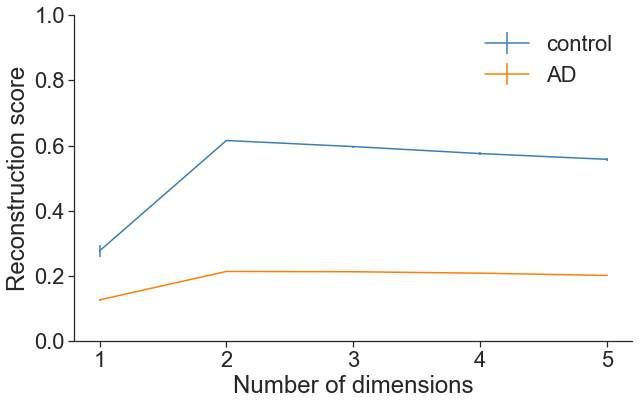

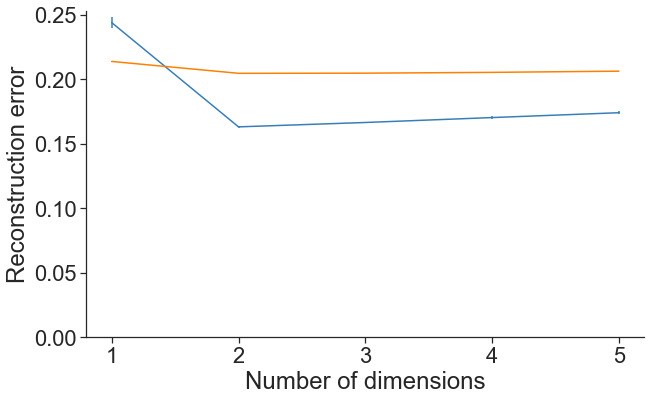

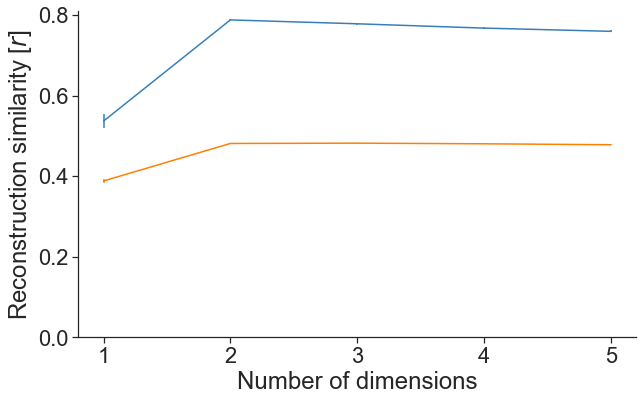

In [98]:
# Non-linear  variance explained
plt.figure(figsize=(10,6))
sem = stats.sem(var_expl['MDS'],1, nan_policy='omit')
plt.errorbar(range(1,DIMS+1), np.nanmean(var_expl['MDS'],1), yerr=sem, label='control', color=colb[0], alpha=1)
sem = stats.sem(var_expl['mds_ad'],1, nan_policy='omit')
plt.errorbar(range(1,DIMS+1), np.nanmean(var_expl['mds_ad'],1), yerr=sem, label='AD', color=colb[1], alpha=1)
plt.legend(frameon=False)
plt.ylim(0,1)
plt.xticks(range(1,DIMS+1))
plt.ylabel('Reconstruction score')
plt.xlabel('Number of dimensions')
sns.despine()
# saving
plt.savefig(figDirAD+'/var_expl_AD.svg')
plt.savefig(figDirAD+'/var_expl_AD.png')

# Reconstuction error
plt.figure(figsize=(10,6))
sem = stats.sem(rec_err['MDS'],1, nan_policy='omit')
plt.errorbar(range(1,DIMS+1), np.nanmean(rec_err['MDS'],1), yerr=sem, label='control', color=colb[0], alpha=1)
sem = stats.sem(rec_err['mds_ad'],1, nan_policy='omit')
plt.errorbar(range(1,DIMS+1), np.nanmean(rec_err['mds_ad'],1), yerr=sem, label='AD', color=colb[1], alpha=1)
plt.ylim(0)
plt.ylabel('Reconstruction error')
plt.xlabel('Number of dimensions')
plt.xticks(range(1,DIMS+1))
sns.despine()
# saving
plt.savefig(figDirAD+'/rec_err_AD.svg')
plt.savefig(figDirAD+'/rec_err_AD.png')

# Reconstuction corr
plt.figure(figsize=(10,6))
sem = stats.sem(rec_corr['MDS'],1, nan_policy='omit')
plt.errorbar(range(1,DIMS+1), np.nanmean(rec_corr['MDS'],1), yerr=sem, label='control', color=colb[0], alpha=1)
sem = stats.sem(rec_corr['mds_ad'],1, nan_policy='omit')
plt.errorbar(range(1,DIMS+1), np.nanmean(rec_corr['mds_ad'],1), yerr=sem, label='AD', color=colb[1], alpha=1)
plt.ylim(0)
plt.ylabel('Reconstruction similarity [$r$]')
plt.xlabel('Number of dimensions')
plt.xticks(range(1,DIMS+1))
sns.despine()
# saving
plt.savefig(figDirAD+'/rec_corr_AD.svg')
plt.savefig(figDirAD+'/rec_corr_AD.png')